<a href="https://colab.research.google.com/github/esrayuzgec/parkinsonvsalz/blob/main/PD_CN_Convnext_Train1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from fastbook import *
import timm
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer

In [ ]:
path = Path('/content/gdrive/MyDrive/3_cls')


In [ ]:
path.ls()

(#8) [Path('/content/gdrive/MyDrive/3_cls/train'),Path('/content/gdrive/MyDrive/3_cls/test'),Path('/content/gdrive/MyDrive/3_cls/alzparkinson_2cls.pth'),Path('/content/gdrive/MyDrive/3_cls/parkinsonCN_resnet18_1.pth'),Path('/content/gdrive/MyDrive/3_cls/parkinsonCN_resnet18_1'),Path('/content/gdrive/MyDrive/3_cls/parkinsonCN_resnet18_1.pkl'),Path('/content/gdrive/MyDrive/3_cls/pdCNVGG16_1.pth'),Path('/content/gdrive/MyDrive/3_cls/pdCNVGG16_1.pkl')]

In [ ]:
item_tfms = Resize(224)
batch_tfms = aug_transforms=[Normalize.from_stats(*imagenet_stats)]

In [ ]:
train_fnames=get_image_files(path/'train')


In [ ]:
dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                  get_items= get_image_files,
                  get_y = parent_label,
                  splitter =RandomSplitter(valid_pct= 0.1),
                  item_tfms = item_tfms,
                  batch_tfms = batch_tfms
                  )

In [ ]:
dls = dblock.dataloaders(path,bs=32)

In [ ]:
dls.c,len(dls.train_ds),len(dls.valid_ds)

(2, 4176, 463)

In [ ]:
dls.vocab

['CONTROL', 'PD']

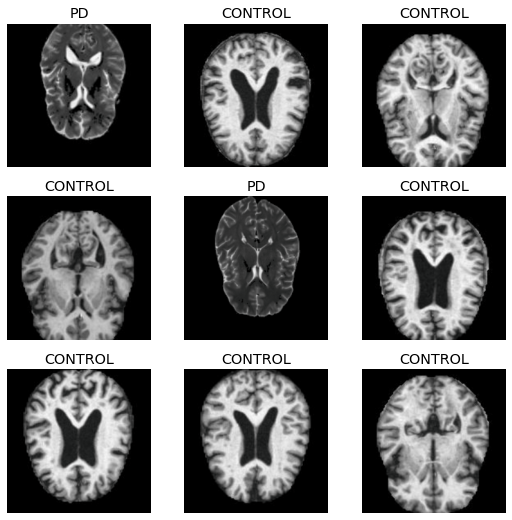

In [ ]:
dls.show_batch()

In [ ]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [ ]:
learn= vision_learner(dls,'convnext_small_in22k',metrics=accuracy)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


SuggestedLRs(valley=0.0005754399462603033)

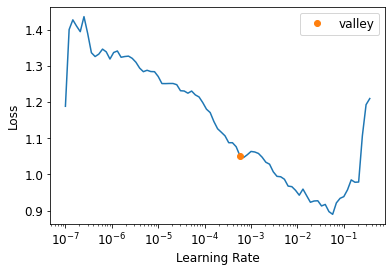

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(100,1.05e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.735673,0.361735,0.898488,03:25
1,0.645845,0.309604,0.917927,01:51
2,0.556542,0.285814,0.915767,01:50
3,0.470179,0.211789,0.939525,01:50
4,0.392882,0.178189,0.958963,01:51
5,0.306548,0.139411,0.963283,01:51
6,0.266479,0.157045,0.939525,01:50
7,0.230699,0.124064,0.948164,01:51
8,0.195404,0.133439,0.943844,01:51
9,0.189238,0.083777,0.961123,01:50


epoch,train_loss,valid_loss,accuracy,time
0,0.735673,0.361735,0.898488,03:25
1,0.645845,0.309604,0.917927,01:51
2,0.556542,0.285814,0.915767,01:50
3,0.470179,0.211789,0.939525,01:50
4,0.392882,0.178189,0.958963,01:51
5,0.306548,0.139411,0.963283,01:51
6,0.266479,0.157045,0.939525,01:50
7,0.230699,0.124064,0.948164,01:51
8,0.195404,0.133439,0.943844,01:51
9,0.189238,0.083777,0.961123,01:50


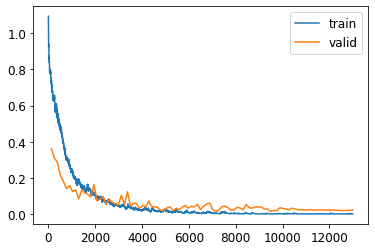

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)

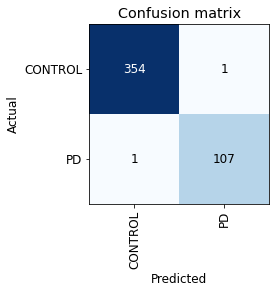

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.save(path/'PADCN_convnext')

Path('/content/gdrive/MyDrive/3_cls/PADCN_convnext.pth')

In [ ]:
learn.export(path/'PADCN_convnext.pkl')

In [ ]:
interp.print_classification_report()


              precision    recall  f1-score   support

     CONTROL       1.00      1.00      1.00       355
          PD       0.99      0.99      0.99       108

    accuracy                           1.00       463
   macro avg       0.99      0.99      0.99       463
weighted avg       1.00      1.00      1.00       463



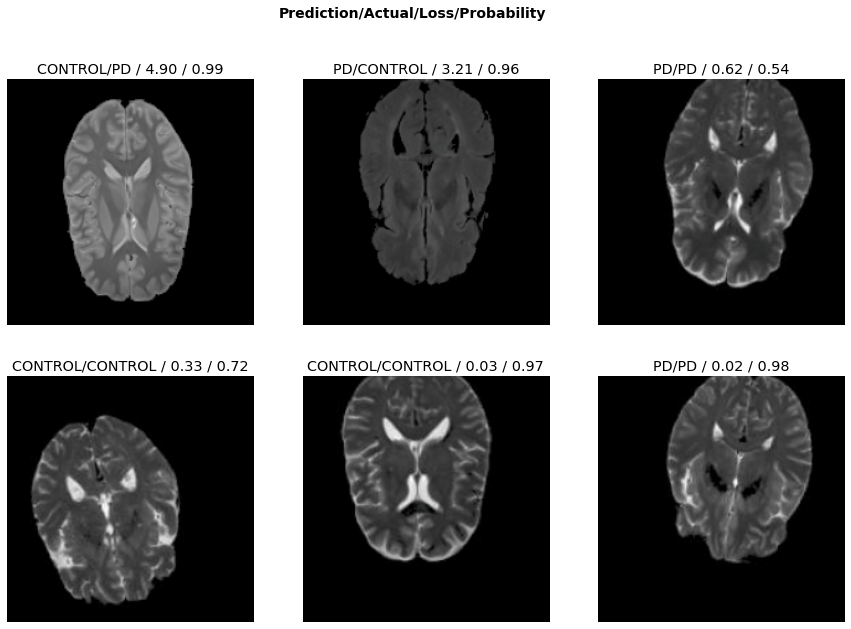

In [ ]:
interp.plot_top_losses(6, figsize=(15,10))


In [ ]:
all_files= get_image_files(path)


In [ ]:

dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                 get_y=parent_label,
                 
                 item_tfms = Resize(224),
                 batch_tfms =[Normalize.from_stats(*imagenet_stats)]
              
                 
)
 

In [ ]:
dls_test = dblock.dataloaders(all_files)


In [ ]:
print("Number of examples in testing:", len(dls_test.valid_ds))


Number of examples in testing: 723


In [ ]:
learn1 = vision_learner(dls_test, 'convnext_small_in22k', metrics=accuracy).load('/content/gdrive/MyDrive/3_cls/PADCN_convnext')


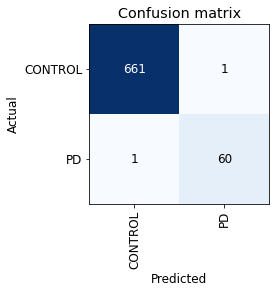

In [ ]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [ ]:
preds, targs = learn1.tta()
accuracy(preds, targs).item()


0.9972337484359741

In [ ]:
interp.most_confused()


[('CONTROL', 'PD', 1), ('PD', 'CONTROL', 1)]

In [ ]:
losses,idxs = interp.top_losses(10)
print(idxs)

TensorBase([  9, 720,  44,  29,  18,  15,   2,  54,  24,  22])


In [ ]:
dls_test.valid_ds.items[9]


Path('/content/gdrive/MyDrive/3_cls/test/PD/PD_358.png')

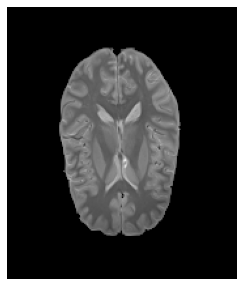

In [ ]:

img = PILImage.create('/content/gdrive/MyDrive/3_cls/test/PD/PD_358.png')
img.show()

In [ ]:

learn1.predict(img)

('CONTROL', TensorBase(0), TensorBase([0.9926, 0.0074]))

In [ ]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [ ]:
m = learn1.model.eval();
m;

In [ ]:
target_layer = learn1.model[0]

target_layer;

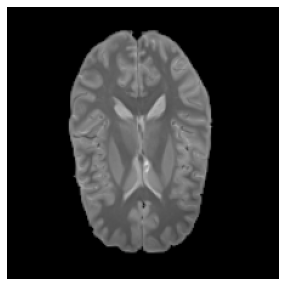

In [ ]:

x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [ ]:

class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn1.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]
     

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
     

In [ ]:
def plot_gradcam(img, learn1, hooked_layer, size=224):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls_test.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 2, 1], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookGradient(hooked_layer) as hookg:
            with HookActivation(hooked_layer) as hook:
                output = learn1.model.eval()(x.cuda())
                act = hook.stored
            output[0, i-1].backward()
            grad = hookg.stored
            p_high, p_low = output.cpu().detach()[0]

        w = grad[0].mean(dim=(1,2), keepdim=True)
        gradcam_map = (w * act[0]).sum(0).detach().cpu()

        # thresholding to account for ReLU
        gradcam_map = torch.clamp(gradcam_map, min=0) 

        x_img.show(ax=ax)
        ax.imshow(
            gradcam_map, alpha=0.6, extent=(0, size, size,0),
            interpolation='mitchell', cmap='hot'
        )
        ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    
    return (fig, axes, *(np.exp([p_low, p_high]) / np.exp([p_low, p_high]).sum()))
     

(<Figure size 1275x450 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d202bd460>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f5d202d3fa0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5d204bf430>], dtype=object),
 0.0074249045,
 0.9925751)

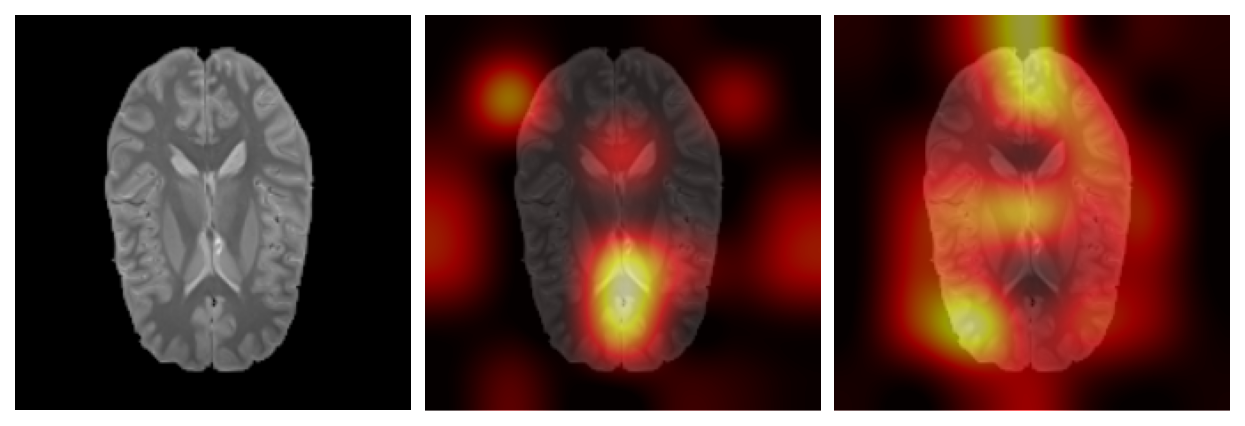

In [ ]:

plot_gradcam(x_img,learn1,target_layer)